In [1]:
# hexadecimal

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections, transforms
import os
import re
import matplotlib.tri as tri

In [3]:
# file paths markers
mark_start  = re.compile(r"\(2\s(?P<DIMEN>2|3)\)")
mark_nodes  = re.compile(r"\(10\s\((\d)\s(\d+)\s(\d+)\s(\d+)\s(\d+)\)\(")
mark_cells  = re.compile(r"\(12\s\((\d)\s(\d+)\s(\d+)\s(\d+)\s(\d+)\)\(")
mark_faces  = re.compile(r"\(13\s\((\d)\s(\d+)\s(\d+)\s(\d+)\s(\d+)\)\(")
mark_others = re.compile(r"\((18|58|59|61)\s\((\d)\s(\d+)\s(\d+)\s(\d+)\s(\d+)\)\(")
mark_names  = re.compile(r"\(45\s\((\d)\s(\d+)\s(\d+)\s(\d+)\s(\d+)\)\(")
mark_ends   = re.compile(r"\)\)")
mark_ends_faces   = re.compile(r"^\s*$")

In [4]:
#filename = 'book_task.msh'                              # book-hex rectangular mesh
filename = '_meshbook_task_tet.msh'                      # book-tet rectangular mesh

## Обработка сетки

In [5]:
# Читается файл с сеткой в качестве выходных данных
# facename2index - индекс - нaзвание области  1: 'interior-geom'
# nodes_list  - сквозной список координат узлов 
# node_index  - индексы областей с узлами
# node2zone   - номера узлов в областях node_index
# inter_faces - сквозной список граней  n0 n1 n2 cr cl, если  cl = 0 то эта грань внешняя
# zone_index  - индекс областей всех подряд
# faces2zone -  номера граней в областях zone_index
facename2index = {}
nodes_list = []
node_index = []
node2zone = []
inter_faces = []
zone_index = []
faces2zone = []
mark_face_cell = re.compile(r"\((10|13)\s\((?P<id>\w+)\s(?P<st_val>\w+)\s(?P<fin_val>\w+)\s(\w+)\s(\w+)\)(?:\(|$)")
mark_end = re.compile(r"(\)\)|^\s*$|\))")
with open (filename, "r") as f:
    # read upto the dimension section and check dimension of the task
    for line in f:
        if re.search(r"\(2\s(?P<DIMEN>2|3)\)", line):
            dimension = re.search(r"\(2\s(?P<DIMEN>2|3)\)", line)['DIMEN']
            print('Размерность сетки:', dimension)
            if dimension != '2':
                print('Обработка для 3D сетки еще не выполнена')
                exit()
            break
    # continue read the file
    for line in f:
        # search for node data and aggregate full list of node X , Y , Z(not now)
        if re.findall(r"\(10\s\(\w+\s\w+\s\w+\s\w+\s\w+\)(?:\(|$)", line):
            obj = mark_face_cell.search(line)
            node_index.append(int(obj['id'], 16))
            node2zone.append([int(obj['st_val'], 16) - 1, int(obj['fin_val'], 16)])
            line = f.readline()
            if re.search(r"\(", line):
                line = f.readline()
            while not mark_end.findall(line):
                extracted = [float(item) for item in line.strip().split()]
                nodes_list.append(extracted)
                line = f.readline()
        # search for face data and aggregate full list of face v1, v2, el1, el2
        if re.findall(r"\(13\s\(\w+\s\w+\s\w+\s\w+\s\w+\)\(", line):
            obj = mark_face_cell.search(line)
            zone_index.append(int(obj['id'], 16))
            faces2zone.append([int(obj['st_val'], 16) - 1, int(obj['fin_val'], 16)])
            line = f.readline() 
            while not mark_end.findall(line):
                extracted = [int(item, 16) for item in line.strip().split()]
                inter_faces.append(extracted)
                line = f.readline()
        if re.findall(r"\((45|39)\s\(\w+\s(\w+-\w+|\w+)\s(\w+-\w+|\w+)", line):
            obj = re.search(r"\((45|39)\s\((?P<id>\w+)\s(\w+-\w+|\w+)\s(?P<name>\w+-\w+|\w+)", line)
            facename2index[int(obj['id'])] = obj['name']
nodes_list = [[i + 1] + row for i, row in enumerate(nodes_list)]
inter_faces = [[i + 1] + row for i, row in enumerate(inter_faces)]

Размерность сетки: 2


In [6]:
facename2index

{1: 'interior-geom',
 2: 'geom-2_surface',
 3: 'solid-geom',
 6: 'tempsurf',
 7: 'insulsurf',
 8: 'fluxsurf',
 9: 'convsurf'}

In [7]:
%%time
# facebyzone - разбивка граней по названиям зон facename2index где есть элементы  interior-geom': [[1, 6, 1, 1, 2],....
facebyzone = {}
for i, item in enumerate(zone_index):
    facebyzone[facename2index[item]] = inter_faces[faces2zone[i][0]:faces2zone[i][1]][:]

CPU times: total: 0 ns
Wall time: 0 ns


In [8]:
%%time
# el_list_num - явное перечисление номеров элементов
# el_list - элементы и узлы из которых они состоят
el_list_num = set([row[3] for row in inter_faces])
el_list_num = list(el_list_num.union(set([row[4] for row in inter_faces])))

el_list_num.remove(0)
el_list = []
for num in el_list_num:
    ex = set([row[1] for row in inter_faces if (row[3] == num) or (row[4] == num)])
    ex = list(ex.union(set([row[2] for row in inter_faces if (row[3] == num) or (row[4] == num)])))
    el_list.append([num] + ex)

CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
# обработка данных для numpy, определение общего количества граней, узлов и элементов
nodes_list = np.array(nodes_list)
nodes_list = nodes_list[:, 1:]
el_list = np.array(el_list)
el_list = el_list[:, 1:] - 1
inter_faces = np.array(inter_faces)
inter_faces = inter_faces[:, 1:]-1
facebyzone = facebyzone
ne = len(el_list)
nf = len(inter_faces)
nn = len(nodes_list)

In [10]:
## Сортировка порядка узлов для 4х узловых элементов, для отображения
for i in range(ne):
    nodIndX = el_list[i,:].copy()
    ll = len(nodIndX)
    dist = np.linalg.norm(nodes_list[nodIndX[1:ll]]-nodes_list[el_list[i,0]], axis=1)
    indXs = np.argsort (dist) + 1
    el_list[i,1] = nodIndX[indXs[0]]
    el_list[i,2:] = nodIndX[np.flipud(indXs[1:])]

In [11]:
# определение характеристик элементов
# el_quantities[i, 0] - Xel проекция координаты центра тяжести элемента на ось X
# el_quantities[i, 1] - Yel проекция координаты центра тяжести элемента на ось Y
# el_quantities[i, 2] - площадь элемента
el_quantities = np.zeros((ne, 3))
for i in range (ne):
    indX = el_list[i,:]
    quant = len(indX)
    el_quantities[i, 0] = sum (nodes_list[indX, 0])/quant
    el_quantities[i, 1] = sum (nodes_list[indX, 1])/quant
    if quant  == 3:
        normal2tri = np.cross(nodes_list[indX[1]] - nodes_list[indX[0]], nodes_list[indX[2]] - nodes_list[indX[0]])
        el_quantities[i, 2] = np.linalg.norm(normal2tri) / 2
    else:
        SXC = 0
        SYC = 0
        for kk in range (quant-1):
            Xc = (nodes_list[indX[kk+1], 0] + nodes_list[indX[kk], 0] + el_quantities[i, 0]) / 3
            Yc = (nodes_list[indX[kk+1], 1] + nodes_list[indX[kk], 1] + el_quantities[i, 1]) / 3
            normal2tri = np.cross(nodes_list[indX[kk+1]] - nodes_list[indX[kk]], [el_quantities[i, 0], el_quantities[i, 1]] - nodes_list[indX[kk]])
            el_quantities[i, 2] += np.linalg.norm(normal2tri) / 2
            SXC +=  np.linalg.norm(normal2tri) / 2 * Xc
            SYC +=  np.linalg.norm(normal2tri) / 2 * Yc
        Xc = (nodes_list[indX[0], 0] + nodes_list[indX[-1], 0] + el_quantities[i, 0]) / 3
        Yc = (nodes_list[indX[0], 1] + nodes_list[indX[-1], 1] + el_quantities[i, 1]) / 3
        normal2tri = np.cross(nodes_list[indX[0]] - nodes_list[indX[-1]], [el_quantities[i, 0], el_quantities[i, 1]] - nodes_list[indX[-1]])
        el_quantities[i, 2] += np.linalg.norm(normal2tri) / 2
        SXC +=  np.linalg.norm(normal2tri) / 2 * Xc
        SYC +=  np.linalg.norm(normal2tri) / 2 * Yc
        el_quantities[i, 0] = SXC/el_quantities[i, 2]
        el_quantities[i, 1] = SYC/el_quantities[i, 2]

In [12]:
# определение характеристик граней
# face_quantities[i,0:2]     - CF вектор
# face_quantities[i,2]       - length of CF
# face_quantities[i,3:5]     - ecf                 
# face_quantities[i,5:7]     - Sf1 - n to line    
# face_quantities[i,7]       - length of Sf1
# face_quantities[i,8:10]    - esf                   
# face_quantities[i,10:12]   - rf - rf'  вектор                  
# face_quantities[i,12]      - gs'                
# face_quantities[i,13:15]   - Ef1       вектор
# face_quantities[i,15:17]   - Tf1       вектор
# face_quantities[i,17]      - Tf1  length of Tf1

face_quantities = np.full((nf,20), fill_value = -1, dtype = float)

# берем первые две name zone и последний индекс грани - будет ли работать на других сетках больой вопрос надо проверять + проверка если гу зоны не объявлены
inner_faces = np.max(faces2zone[0:2]) if len(facename2index)>3 else np.max(faces2zone[0:1])           

# для внутренних граней
for i in range(inner_faces):
    indX = inter_faces[i,:]
    rf = 0.5*(nodes_list[indX[1]] + nodes_list[indX[0]])
    e2line = np.array([nodes_list[indX[1], 1] - nodes_list[indX[0], 1], -(nodes_list[indX[1], 0] - nodes_list[indX[0], 0])]) # нормаль не нормирована - модуль это длина линии 
    rC = el_quantities[indX[2], 0:2]
    rF = el_quantities[indX[3], 0:2]
    dCF = rF - rC                                                                                   # CF - vector из конца в начало 
    dCf = rf - rC
    dFf = rf - rF
    face_quantities[i,0:2]   = dCF                                                                   # CF                  
    face_quantities[i,2]     = np.linalg.norm(dCF)                                                   # CF                  length of CF
    face_quantities[i,3:5]   = dCF/face_quantities[i,2]                                              # ecf                 
    face_quantities[i,5:7]   = np.sign(np.dot(dCF, e2line))*e2line                                   # Sf1 - n to line    
    face_quantities[i,7]     = np.linalg.norm(face_quantities[i,5:7])                                # Sf1 - n to line     length of Sf1
    face_quantities[i,8:10]  = face_quantities[i,5:7]/face_quantities[i,7]                           # esf                   
    face_quantities[i,10:12] = dCf - np.dot(dCf, dCF)/np.dot(dCF, dCF)*(dCF)                         # rf - rf'            ! исправлено          
    face_quantities[i,12]    = np.linalg.norm(-dFf + face_quantities[i,10:12])/np.linalg.norm(dCF)    # gs'                 ! исправлено
    face_quantities[i,13:15] = np.dot(face_quantities[i,5:7], 
                                      face_quantities[i,5:7])/np.dot(face_quantities[i,3:5], 
                                                                     face_quantities[i,5:7])*face_quantities[i,3:5]      #  Ef1
    face_quantities[i,15:17] = face_quantities[i,5:7] -face_quantities[i,13:15]                                          #  Tf1
    face_quantities[i,17]    = np.linalg.norm(face_quantities[i,13:15])                                                  #  Tf1  length of Tf1
    face_quantities[i,18:20] = rf                                                                     #  rf
# для внешних граней
for i in range(inner_faces, nf):
    indX = inter_faces[i,:]
    rb = 0.5*(nodes_list[indX[1]] + nodes_list[indX[0]])
    e2line  = np.array([nodes_list[indX[1], 1] - nodes_list[indX[0], 1], -(nodes_list[indX[1], 0] - nodes_list[indX[0], 0])])  # нормаль не нормирована - модуль это длина линии 
    rC = el_quantities[indX[2], 0:2]
    dCb = rb - rC
    face_quantities[i,0:2]   = dCb                                                                   # Cb                  
    face_quantities[i,2]     = np.linalg.norm(dCb)                                                   # Cb                  length of CF
    face_quantities[i,3:5]   = dCb/face_quantities[i,2]                                              # ecb                 
    face_quantities[i,5:7]   = np.sign(np.dot(dCb, e2line))*e2line                                   # Sf1 - n to line    
    face_quantities[i,7]     = np.linalg.norm(face_quantities[i,5:7])                                # Sf1 - n to line     length of Sf1
    face_quantities[i,8:10]  = face_quantities[i,5:7]/face_quantities[i,7]                           # esf                   
    face_quantities[i,10:12] = [0, 0]                                                                # rf - rf'            ! исправлено          
    face_quantities[i,12]    = 0                                                                     # gs'                 ! исправлено
    face_quantities[i,13:15] = np.dot(face_quantities[i,5:7], 
                                      face_quantities[i,5:7])/np.dot(face_quantities[i,3:5], 
                                                                     face_quantities[i,5:7])*face_quantities[i,3:5]      #  Ef1
    face_quantities[i,15:17] = face_quantities[i,5:7] - face_quantities[i,13:15]                                           #  Tf1
    face_quantities[i,17]    = np.linalg.norm(face_quantities[i,13:15])                              #  Ef1  length of Ef1
    face_quantities[i,18:20] = rb 
face_quantities[inner_faces-1, :]

array([-6.04162824e-02, -3.43048260e-02,  6.94762424e-02, -8.69596286e-01,
       -4.93763404e-01, -1.06730092e-01, -0.00000000e+00,  1.06730092e-01,
       -1.00000000e+00, -0.00000000e+00,  9.96887801e-04, -1.75567878e-03,
        5.35227330e-01, -1.06730092e-01, -6.06021605e-02,  0.00000000e+00,
        6.06021605e-02,  1.22735221e-01,  1.00000000e-01,  1.49815605e-01])

In [13]:
# Для демонстрации сетки
def plot_fem_mesh(nodes_x, nodes_y, elements):
    for element in elements:
        x = [nodes_x[element[i]] for i in range(len(element))]
        y = [nodes_y[element[i]] for i in range(len(element))]
        plt.fill(x, y, edgecolor='black', fill=False)

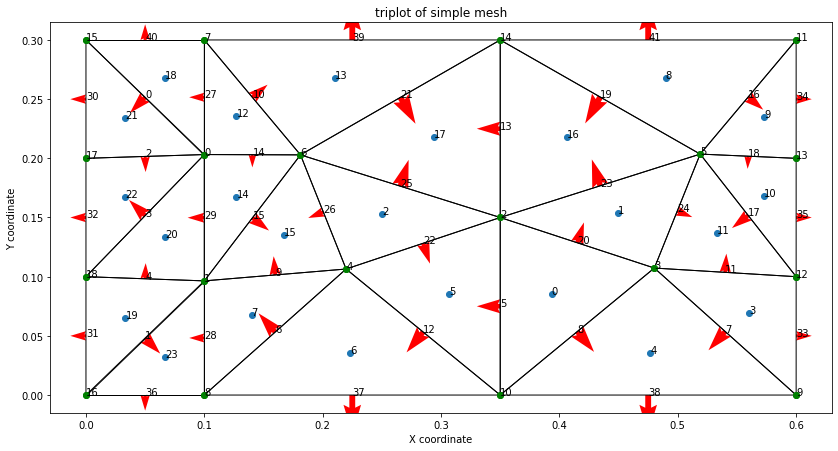

In [14]:
# Демонстрация сетки с нормалями для проверки
norm_size2viz = 5                                           # масштаб отобращения длин нормалей для визуализации
fig2, ax2 = plt.subplots(figsize=(14,10))
ax2.set_aspect('equal')
ax2.plot(nodes_list[:, 0], nodes_list[:, 1], 'go', lw=1.0)
#ax2.triplot(nodes_list[:, 0], nodes_list[:, 1], el_list, 'go-', lw=1.0)
plot_fem_mesh(nodes_list[:, 0], nodes_list[:, 1], el_list)
ax2.plot(el_quantities[:, 0], el_quantities[:, 1], 'o')
[ax2.quiver(face_quantities[i,18], face_quantities[i,19], 
            face_quantities[i,5], face_quantities[i,6],
            scale=norm_size2viz, color='r') for i in range(nf)]
texts = [ax2.text(el_quantities[i, 0]+1e-5, el_quantities[i, 1]+1e-5, '%s' %i) for i in range(ne)]
texts = [ax2.text(face_quantities[i,18]+1e-5, face_quantities[i,19]+1e-5, '%s' %i) for i in range(nf)]
ax2.plot(nodes_list[:, 0], nodes_list[:, 1], 'go', lw=1.0)
texts = [ax2.text(nodes_list[i, 0]+1e-5, nodes_list[i, 1]+1e-5, '%s' %i) for i in range(nn)]
ax2.set_title('triplot of simple mesh')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
#ax2.set_xlim(-0.02, 0.02)   # set the xlim to left, right
plt.show()

**Выделение поверхностей под ГУ**

In [15]:
facename2index

{1: 'interior-geom',
 2: 'geom-2_surface',
 3: 'solid-geom',
 6: 'tempsurf',
 7: 'insulsurf',
 8: 'fluxsurf',
 9: 'convsurf'}

In [16]:
inner_faces = list(range(np.min(faces2zone[0]), np.max(faces2zone[1])))
inner_faces

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [17]:
tempsurf_id = zone_index.index(6)
tempsurf_faces = list(range(faces2zone[tempsurf_id][0], faces2zone[tempsurf_id][1]))
tempsurf_faces

[30, 31, 32]

In [18]:
insulsurf_id = zone_index.index(7)
insulsurf_faces = list(range(faces2zone[insulsurf_id][0], faces2zone[insulsurf_id][1]))
insulsurf_faces

[33, 34, 35, 36]

In [19]:
fluxsurf_id = zone_index.index(8)
fluxsurf_faces = list(range(faces2zone[fluxsurf_id][0], faces2zone[fluxsurf_id][1]))
fluxsurf_faces

[37, 38]

In [20]:
convsurf_id = zone_index.index(9)
convsurf_faces = list(range(faces2zone[convsurf_id][0], faces2zone[convsurf_id][1]))
convsurf_faces

[39, 40, 41]

## Решение тепловой задачи

In [21]:
kmat = np.full((nf,1), fill_value = 50, dtype = float)

**Начальные условия**

In [22]:
Tstart = 300

**Граничные условия**

In [23]:
Tbc = 300            # Dirichlet Boundary Condition  - zone1
qbc0 = 0             # Neumann Boundary Condition    - zone2
qbc1 = -5000          # Neumann Boundary Condition    - zone3
Tc  = 400            # Robin                         - zone4
hc  = 20             # Boundary Condition            - zone4

**Значения на гранях, градиенты в объемах и градиенты на гранях для граничных граней**

In [24]:
Val2face =  np.zeros((nf, 3))   # face values (X and dX)
Val2node =  np.zeros((ne, 3))   # node values (X and dX)
Val2node[:, 0] = Tstart
for face_id in inner_faces:
    el_indx = inter_faces[face_id][2:4]
    Val2face[face_id,0] =  Val2node[el_indx[0], 0] * face_quantities[face_id,12] + (1-face_quantities[face_id,12])*Val2node[el_indx[1], 0]    # f' =  Fc*gf' + Ff*(1-gf')
    Val2node[el_indx[0], 1] +=  Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
    Val2node[el_indx[0], 2] +=  Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]
    Val2node[el_indx[1], 1] -=  Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[1], 2]
    Val2node[el_indx[1], 2] -=  Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[1], 2]
for face_id in tempsurf_faces:
    el_indx = inter_faces[face_id][2:4]
    Val2face[face_id,0] = Tbc                                                                                          #  Dirichlet ?
    Val2face[face_id,1] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,5]/ face_quantities[face_id,2]
    Val2face[face_id,2] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,6]/ face_quantities[face_id,2]
    Val2node[el_indx[0], 1] +=  Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
    Val2node[el_indx[0], 2] +=  Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]
for face_id in insulsurf_faces:
    el_indx = inter_faces[face_id][2:4]
    dl = face_quantities[face_id,7]/face_quantities[face_id,2]                                                         # Neumann q = 0 ?
    Val2face[face_id,0] = (kmat[face_id] *Val2node[el_indx[0], 0] * dl + qbc0) / kmat[face_id] / dl                          # в исходном варианте знак "-" !!!
    Val2face[face_id,1] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,5]/ face_quantities[face_id,2]
    Val2face[face_id,2] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,6]/ face_quantities[face_id,2]
    Val2node[el_indx[0], 1] += Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
    Val2node[el_indx[0], 2] += Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]
for face_id in fluxsurf_faces:
    el_indx = inter_faces[face_id][2:4]
    dl = face_quantities[face_id,7]/face_quantities[face_id,2]                                                             # Neumann
    Val2face[face_id,0] = (kmat[face_id] *Val2node[el_indx[0], 0] * dl +  qbc1) / kmat[face_id] / dl                         # в исходном варианте знак "-" !!!
    Val2face[face_id,1] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,5]/ face_quantities[face_id,2]
    Val2face[face_id,2] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,6]/ face_quantities[face_id,2]
    Val2node[el_indx[0], 1] += Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
    Val2node[el_indx[0], 2] += Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]
for face_id in convsurf_faces:
    el_indx = inter_faces[face_id][2:4]
    val = kmat[face_id]/face_quantities[face_id,2]
    Val2face[face_id,0] =  (Tc*hc + val*Val2node[el_indx[0], 0]) / (hc+val)                                            # Robin
    Val2face[face_id,1] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,5]/ face_quantities[face_id,2]
    Val2face[face_id,2] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,6]/ face_quantities[face_id,2]
    Val2node[el_indx[0], 1] += Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
    Val2node[el_indx[0], 2] += Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]

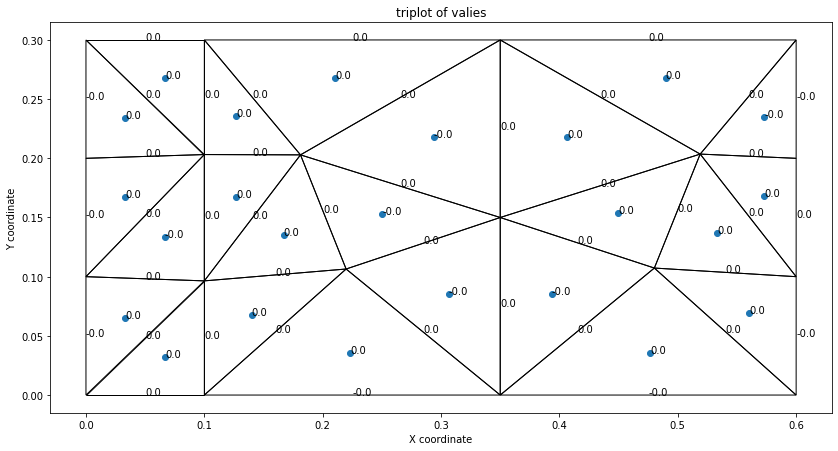

In [25]:
# Демонстрация сетки с нормалями для проверки
norm_size2viz = 5                                           # масштаб отобращения длин нормалей для визуализации
fig2, ax2 = plt.subplots(figsize=(14,10))
ax2.set_aspect('equal')
plot_fem_mesh(nodes_list[:, 0], nodes_list[:, 1], el_list)
ax2.plot(el_quantities[:, 0], el_quantities[:, 1], 'o')

texts = [ax2.text(el_quantities[i, 0]+1e-5, el_quantities[i, 1]+1e-5, '%s'%np.round(Val2node[i,1],1)) for i in range(ne)]      #
texts = [ax2.text(face_quantities[i,18]+1e-5, face_quantities[i,19]+1e-5, '%s' %np.round(Val2face[i,1],1)) for i in range(nf)]  #
#texts = [ax2.text(nodes_list[i, 0]+1e-5, nodes_list[i, 1]+1e-5, '%s' %i) for i in range(nn)]            # 
#t
ax2.set_title('triplot of valies')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
plt.show()

**Градиенты на гранях для внутренних граней (пока отключил поправки)**

In [26]:
for face_id in inner_faces:
    el_indx = inter_faces[face_id][2:4]
    Val2face[face_id,1] =  Val2node[el_indx[0], 1]* face_quantities[face_id,12] + (1-face_quantities[face_id,12])*Val2node[el_indx[1], 1]    # f' =  Fc*gf' + Ff*(1-gf')
    Val2face[face_id,2] =  Val2node[el_indx[0], 2]* face_quantities[face_id,12] + (1-face_quantities[face_id,12])*Val2node[el_indx[1], 2]    # f' =  Fc*gf' + Ff*(1-gf')
    Val2face[face_id,1:3] = Val2face[face_id,1:3] + ((Val2node[el_indx[1], 0] - Val2node[el_indx[0], 0])/face_quantities[face_id,2] 
                                                     - np.dot(Val2face[face_id,1:3],face_quantities[face_id,3:5]))*face_quantities[face_id,3:5]
    Val2face[face_id,0]   = Val2face[face_id,0] + np.dot(Val2face[face_id,1:3], face_quantities[face_id,10:12])
    Val2node[el_indx[0], 1] += Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
    Val2node[el_indx[0], 2] += Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]
    Val2node[el_indx[1], 1] -= Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[1], 2]
    Val2node[el_indx[1], 2] -= Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[1], 2]

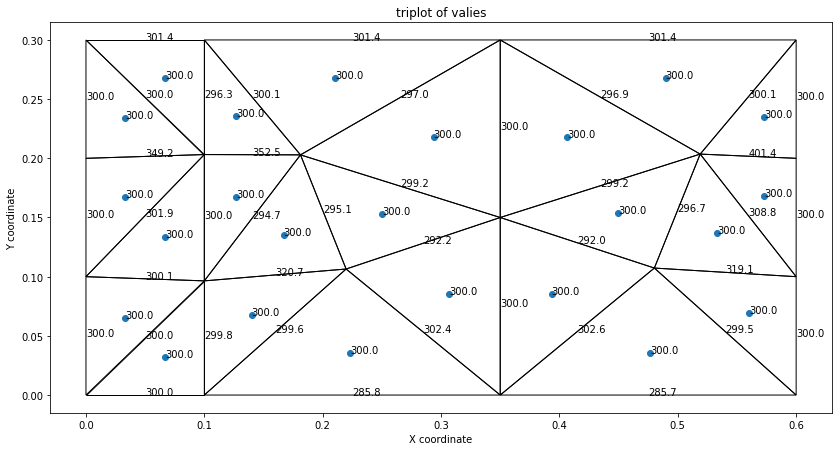

In [27]:
# Демонстрация сетки с нормалями для проверки
norm_size2viz = 5                                           # масштаб отобращения длин нормалей для визуализации
fig2, ax2 = plt.subplots(figsize=(14,10))
ax2.set_aspect('equal')
plot_fem_mesh(nodes_list[:, 0], nodes_list[:, 1], el_list)
ax2.plot(el_quantities[:, 0], el_quantities[:, 1], 'o')

texts = [ax2.text(el_quantities[i, 0]+1e-5, el_quantities[i, 1]+1e-5, '%s'%np.round(Val2node[i,0],1)) for i in range(ne)]      #
texts = [ax2.text(face_quantities[i,18]+1e-5, face_quantities[i,19]+1e-5, '%s' %np.round(Val2face[i,0],1)) for i in range(nf)]  #
#texts = [ax2.text(nodes_list[i, 0]+1e-5, nodes_list[i, 1]+1e-5, '%s' %i) for i in range(nn)]            # 

ax2.set_title('triplot of valies')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
plt.show()

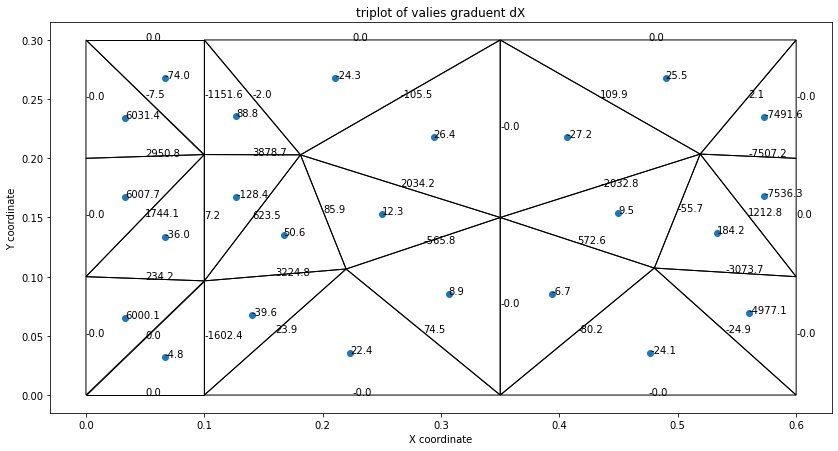

In [28]:
# Демонстрация сетки с нормалями для проверки
norm_size2viz = 5                                           # масштаб отобращения длин нормалей для визуализации
fig2, ax2 = plt.subplots(figsize=(14,10))
ax2.set_aspect('equal')
plot_fem_mesh(nodes_list[:, 0], nodes_list[:, 1], el_list)
ax2.plot(el_quantities[:, 0], el_quantities[:, 1], 'o')

texts = [ax2.text(el_quantities[i, 0]+1e-5, el_quantities[i, 1]+1e-5, '%s'%np.round(Val2node[i,1],1)) for i in range(ne)]      #
texts = [ax2.text(face_quantities[i,18]+1e-5, face_quantities[i,19]+1e-5, '%s' %np.round(Val2face[i,1],1)) for i in range(nf)]  #
#texts = [ax2.text(nodes_list[i, 0]+1e-5, nodes_list[i, 1]+1e-5, '%s' %i) for i in range(nn)]            # 

ax2.set_title('triplot of valies graduent dX')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
plt.show()

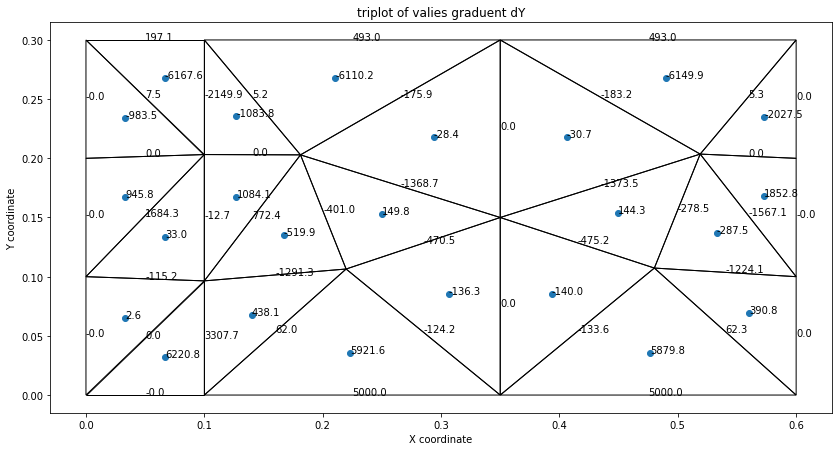

In [29]:
# Демонстрация сетки с нормалями для проверки
norm_size2viz = 5                                           # масштаб отобращения длин нормалей для визуализации
fig2, ax2 = plt.subplots(figsize=(14,10))
ax2.set_aspect('equal')
plot_fem_mesh(nodes_list[:, 0], nodes_list[:, 1], el_list)
ax2.plot(el_quantities[:, 0], el_quantities[:, 1], 'o')

texts = [ax2.text(el_quantities[i, 0]+1e-5, el_quantities[i, 1]+1e-5, '%s'%np.round(Val2node[i,2],1)) for i in range(ne)]      #
texts = [ax2.text(face_quantities[i,18]+1e-5, face_quantities[i,19]+1e-5, '%s' %np.round(Val2face[i,2],1)) for i in range(nf)]  #
#texts = [ax2.text(nodes_list[i, 0]+1e-5, nodes_list[i, 1]+1e-5, '%s' %i) for i in range(nn)]            # 

ax2.set_title('triplot of valies graduent dY')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
plt.show()

**Формирование матриц**

In [30]:
A = np.zeros([ne, ne])
b = np.zeros([ne,1])
for face_id in inner_faces:
    el_indx = inter_faces[face_id][2:4]
    b [el_indx[0], 0] += kmat[face_id]* np.dot(Val2face[face_id,1:3],face_quantities[face_id,15:17])       # dFf*Tf1 нужно ли k ???
    A [el_indx[0], el_indx[0]] +=  kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]    # length of Ef1/ CF  нужно ли k ???
    A [el_indx[0], el_indx[1]] += -kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]    # length of Ef1/ CF  нужно ли k ???
    A [el_indx[1], el_indx[0]] += -kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]    # length of Ef1/ CF  нужно ли k ???
    A [el_indx[1], el_indx[1]] +=  kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]    # length of Ef1/ CF  нужно ли k ???
for face_id in tempsurf_faces:
    el_indx = inter_faces[face_id][2:4]
    fluxC = kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]
    A [el_indx[0], el_indx[0]] +=  fluxC    # length of Ef1/ CF  нужно ли k ???
    b [el_indx[0], 0] += kmat[face_id]*np.dot(Val2face[face_id,1:3],face_quantities[face_id,15:17]) + fluxC*Tbc
for face_id in insulsurf_faces:
    el_indx = inter_faces[face_id][2:4]
    b [el_indx[0], 0] += qbc0*face_quantities[face_id,7]                   # почему "+" ???
for face_id in fluxsurf_faces:
    el_indx = inter_faces[face_id][2:4]
    b [el_indx[0], 0] += qbc1*face_quantities[face_id,7]                   # почему "+" ???
for face_id in convsurf_faces:
    el_indx = inter_faces[face_id][2:4]
    val = kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]          # k*Ef1/db   
    fluxC = hc*face_quantities[face_id,7]*val/(hc*face_quantities[face_id,7]+val) 
    A [el_indx[0], el_indx[0]] +=  fluxC
    b [el_indx[0], 0] += fluxC*Tc +  kmat[face_id]*hc*face_quantities[face_id,7]/(hc*face_quantities[face_id,7]+val)* np.dot(Val2face[face_id,1:3],face_quantities[face_id,15:17])

**Решение матричного уравнения**

In [31]:
X = np.linalg.solve(A, b)
X

array([[ -34.25421301],
       [ -43.70534868],
       [  83.03603744],
       [-126.70496422],
       [ -88.87873806],
       [  49.68291131],
       [  93.69900763],
       [ 143.76604819],
       [  24.22857045],
       [   1.20213726],
       [ -48.72325438],
       [ -72.62788546],
       [ 243.38588751],
       [ 167.8883743 ],
       [ 207.171442  ],
       [ 159.65686624],
       [  14.12718662],
       [ 100.16635164],
       [ 271.85873476],
       [ 258.28065201],
       [ 251.22559301],
       [ 285.60459696],
       [ 277.62644182],
       [ 222.9267057 ]])

In [32]:
for i in range(10):
    Val2face =  np.zeros((nf, 3))   # face values (X and dX)
    Val2node =  np.zeros((ne, 3))   # node values (X and dX)
    Val2node[:, 0] = X[:,0]
    for face_id in inner_faces:
        el_indx = inter_faces[face_id][2:4]
        Val2face[face_id,0] =  Val2node[el_indx[0], 0] * face_quantities[face_id,12] + (1-face_quantities[face_id,12])*Val2node[el_indx[1], 0]    # f' =  Fc*gf' + Ff*(1-gf')
        Val2node[el_indx[0], 1] += Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
        Val2node[el_indx[0], 2] += Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]
        Val2node[el_indx[1], 1] -= Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[1], 2]
        Val2node[el_indx[1], 2] -= Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[1], 2]
    for face_id in tempsurf_faces:
        el_indx = inter_faces[face_id][2:4]
        Val2face[face_id,0] = Tbc                                                                                          #  Dirichlet ?
        Val2face[face_id,1] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,5]/ face_quantities[face_id,2]
        Val2face[face_id,2] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,6]/ face_quantities[face_id,2]
        Val2node[el_indx[0], 1] += Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
        Val2node[el_indx[0], 2] += Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]
    for face_id in insulsurf_faces:
        el_indx = inter_faces[face_id][2:4]
        dl = face_quantities[face_id,7]/face_quantities[face_id,2]                                                         # Neumann q = 0 ?
        Val2face[face_id,0] = (kmat[face_id] *Val2node[el_indx[0], 0] * dl + qbc0) / kmat[face_id] / dl                          # в исходном варианте знак "-" !!!
        Val2face[face_id,1] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,5]/ face_quantities[face_id,2]
        Val2face[face_id,2] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,6]/ face_quantities[face_id,2]
        Val2node[el_indx[0], 1] += Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
        Val2node[el_indx[0], 2] += Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]
    for face_id in fluxsurf_faces:
        el_indx = inter_faces[face_id][2:4]
        dl = face_quantities[face_id,7]/face_quantities[face_id,2]                                                             # Neumann
        Val2face[face_id,0] = (kmat[face_id] *Val2node[el_indx[0], 0] * dl +  qbc1) / kmat[face_id] / dl                         # в исходном варианте знак "-" !!!
        Val2face[face_id,1] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,5]/ face_quantities[face_id,2]
        Val2face[face_id,2] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,6]/ face_quantities[face_id,2]
        Val2node[el_indx[0], 1] += Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
        Val2node[el_indx[0], 2] += Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]
    for face_id in convsurf_faces:
        el_indx = inter_faces[face_id][2:4]
        val = kmat[face_id]/face_quantities[face_id,2]
        Val2face[face_id,0] =  (Tc*hc + val*Val2node[el_indx[0], 0]) / (hc+val)                                            # Robin
        Val2face[face_id,1] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,5]/ face_quantities[face_id,2]
        Val2face[face_id,2] =  + kmat[face_id]* (Val2face[face_id,0]-Val2node[el_indx[0], 0])*face_quantities[face_id,6]/ face_quantities[face_id,2]
        Val2node[el_indx[0], 1] += Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
        Val2node[el_indx[0], 2] += Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]
    for face_id in inner_faces:
        el_indx = inter_faces[face_id][2:4]
        Val2face[face_id,1] =  Val2node[el_indx[0], 1]* face_quantities[face_id,12] + (1-face_quantities[face_id,12])*Val2node[el_indx[1], 1]    # f' =  Fc*gf' + Ff*(1-gf')
        Val2face[face_id,2] =  Val2node[el_indx[0], 2]* face_quantities[face_id,12] + (1-face_quantities[face_id,12])*Val2node[el_indx[1], 2]    # f' =  Fc*gf' + Ff*(1-gf')
        ecf = face_quantities[face_id,5:7] /face_quantities[face_id,2]
        Val2face[face_id,1:3] = Val2face[face_id,1:3] + ((Val2node[el_indx[1], 0] - Val2node[el_indx[0], 0])/face_quantities[face_id,2] 
                                                         - np.dot(Val2face[face_id,1:3],face_quantities[face_id,3:5]))*face_quantities[face_id,3:5]
        Val2face[face_id,0]   = Val2face[face_id,0] + np.dot(Val2face[face_id,1:3], face_quantities[face_id,10:12])
        #Val2node[el_indx[0], 1] += kmat[face_id]* Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[0], 2]
        #Val2node[el_indx[0], 2] += kmat[face_id]* Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[0], 2]
        #Val2node[el_indx[1], 1] -= kmat[face_id]* Val2face[face_id,0]*face_quantities[face_id,5] / el_quantities[el_indx[1], 2]
        #Val2node[el_indx[1], 2] -= kmat[face_id]* Val2face[face_id,0]*face_quantities[face_id,6] / el_quantities[el_indx[1], 2]
    A = np.zeros([ne, ne])
    b = np.zeros([ne,1])
    for face_id in inner_faces:
        el_indx = inter_faces[face_id][2:4]
        b [el_indx[0], 0] += kmat[face_id]* np.dot(Val2face[face_id,1:3],face_quantities[face_id,15:17])       # dFf*Tf1 нужно ли k ???
        A [el_indx[0], el_indx[0]] +=  kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]    # length of Ef1/ CF  нужно ли k ???
        A [el_indx[0], el_indx[1]] += -kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]    # length of Ef1/ CF  нужно ли k ???
        A [el_indx[1], el_indx[0]] += -kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]    # length of Ef1/ CF  нужно ли k ???
        A [el_indx[1], el_indx[1]] +=  kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]    # length of Ef1/ CF  нужно ли k ???
    for face_id in tempsurf_faces:
        el_indx = inter_faces[face_id][2:4]
        fluxC = kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]
        A [el_indx[0], el_indx[0]] +=  fluxC    # length of Ef1/ CF  нужно ли k ???
        b [el_indx[0], 0] += kmat[face_id]*np.dot(Val2face[face_id,1:3],face_quantities[face_id,15:17]) + fluxC*Tbc
    for face_id in insulsurf_faces:
        el_indx = inter_faces[face_id][2:4]
        b [el_indx[0], 0] += qbc0*face_quantities[face_id,7]
    for face_id in fluxsurf_faces:
        el_indx = inter_faces[face_id][2:4]
        b [el_indx[0], 0] += qbc1*face_quantities[face_id,7]
    for face_id in convsurf_faces:
        el_indx = inter_faces[face_id][2:4]
        val = kmat[face_id]*face_quantities[face_id,17]/face_quantities[face_id,2]          # k*Ef1/db   
        fluxC = hc*face_quantities[face_id,7]*val/(hc*face_quantities[face_id,7]+val) 
        A [el_indx[0], el_indx[0]] +=  fluxC
        b [el_indx[0], 0] += fluxC*Tc +  kmat[face_id]*hc*face_quantities[face_id,7]/(hc*face_quantities[face_id,7]+val)* np.dot(Val2face[face_id,1:3],face_quantities[face_id,15:17])
    X = np.linalg.solve(A, b)
    print(X[5])

[283.96494814]
[258.43639094]
[262.17551214]
[263.48814038]
[263.23938434]
[263.37100615]
[263.36110313]
[263.3662675]
[263.36690181]
[263.36704865]


In [33]:
np.array([list(el_quantities[:, 0]), list(el_quantities[:, 1])]).T

array([[0.39340278, 0.08576389],
       [0.44971203, 0.1536204 ],
       [0.25034684, 0.15313091],
       [0.56006945, 0.06909722],
       [0.47673611, 0.03576389],
       [0.30659722, 0.08549275],
       [0.22326389, 0.03549275],
       [0.13993056, 0.06764294],
       [0.48964259, 0.26785651],
       [0.57297592, 0.23452317],
       [0.57297592, 0.16785651],
       [0.53304537, 0.13695373],
       [0.12708295, 0.23536504],
       [0.21041628, 0.26763816],
       [0.12708295, 0.16751523],
       [0.1670135 , 0.1352811 ],
       [0.40630925, 0.21785651],
       [0.29374961, 0.21763816],
       [0.06666667, 0.26772688],
       [0.03333333, 0.06548352],
       [0.06666667, 0.1332104 ],
       [0.03333333, 0.23439355],
       [0.03333333, 0.16772688],
       [0.06666667, 0.03215019]])

In [34]:
X[12]

array([292.11036987])

         1, 4.497120082E-01, 1.536203921E-01, 2.720428079E+02
         2, 3.934027851E-01, 8.576389402E-02, 2.687840755E+02
         3, 4.767360985E-01, 3.576388955E-02, 2.616177322E+02
         4, 1.270829439E-01, 2.353650481E-01, 2.928895722E+02
         5, 2.104163021E-01, 2.676381767E-01, 2.891437706E+02
         6, 2.937496006E-01, 2.176381797E-01, 2.822696697E+02
         7, 5.600694418E-01, 6.909722090E-02, 2.636704189E+02
         8, 5.330453515E-01, 1.369537264E-01, 2.693721517E+02
         9, 5.729759336E-01, 1.678565145E-01, 2.713673719E+02
        10, 5.729759336E-01, 2.345231771E-01, 2.756720772E+02
        11, 4.896425903E-01, 2.678565085E-01, 2.782372396E+02
        12, 4.063092470E-01, 2.178565115E-01, 2.776525844E+02
        13, 2.503468394E-01, 1.531309038E-01, 2.807042615E+02
        14, 3.065972328E-01, 8.549275249E-02, 2.727164738E+02
        15, 2.232639045E-01, 3.549275175E-02, 2.735508566E+02
        16, 1.399305612E-01, 6.764293462E-02, 2.842961994E+02
        17, 6.666667014E-02, 3.215018660E-02, 2.923775459E+02
        18, 3.333333507E-02, 6.548351794E-02, 2.965652879E+02
        19, 1.670135111E-01, 1.352811009E-01, 2.854497635E+02
        20, 1.270829439E-01, 1.675152332E-01, 2.901471364E+02
        21, 6.666667014E-02, 1.332104057E-01, 2.942883149E+02
        22, 3.333333507E-02, 1.677268893E-01, 2.975803794E+02
        23, 3.333333507E-02, 2.343935519E-01, 2.985176729E+02
        24, 6.666667014E-02, 2.677268982E-01, 2.978644553E+02

In [35]:
np.array([list(X[4])[0], list(X[6])[0], list(X[5])[0], list(X[7])[0],   list(X[8])[0],  list(X[1])[0],  list(X[2])[0],   list(X[0])[0], list(X[3])[0]])

array([242.35108276, 266.69887516, 263.36704865, 281.297927  ,
       262.8953935 , 257.30810688, 276.26756374, 254.42426669,
       243.73036583])

In [36]:
X

array([[254.42426669],
       [257.30810688],
       [276.26756374],
       [243.73036583],
       [242.35108276],
       [263.36704865],
       [266.69887516],
       [281.297927  ],
       [262.8953935 ],
       [258.70324057],
       [253.61852862],
       [251.25717058],
       [292.11036987],
       [287.36207269],
       [289.71041548],
       [284.06372626],
       [263.9824412 ],
       [277.77973885],
       [297.0184398 ],
       [296.38474229],
       [295.16890122],
       [298.33813769],
       [297.73663937],
       [291.72700922]])

In [37]:
import matplotlib.collections

In [38]:
def showMeshPlot(nodes, elements, values):

    y = nodes[:,0]
    z = nodes[:,1]

    def quatplot(y,z, quatrangles, values, ax=None, **kwargs):

        if not ax: ax=plt.gca()
        yz = np.c_[y,z]
        verts= yz[quatrangles]
        pc = matplotlib.collections.PolyCollection(verts, **kwargs)
        pc.set_array(values)
        ax.add_collection(pc)
        ax.autoscale()
        return pc

    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    pc = quatplot(y,z, np.asarray(elements), values, ax=ax, 
             edgecolor="crimson", cmap="rainbow")
    fig.colorbar(pc, ax=ax)        
    ax.plot(y,z, marker="o", ls="", color="crimson")

    ax.set(title='This is the plot for: quad', xlabel='Y Axis', ylabel='Z Axis')

    plt.show()

nodes = nodes_list
elements = el_list
stresses = X

showMeshPlot(nodes, elements, stresses)

ValueError: Collections can only map rank 1 arrays

<Figure size 432x288 with 2 Axes>

In [39]:
nodesxx = np.array([[0,0], [0,0.5],[0,1],[0.5,0], [0.5,0.5], [0.5,1], [1,0], 
                  [1,0.5],[1,1]])

In [40]:
nodesxx

array([[0. , 0. ],
       [0. , 0.5],
       [0. , 1. ],
       [0.5, 0. ],
       [0.5, 0.5],
       [0.5, 1. ],
       [1. , 0. ],
       [1. , 0.5],
       [1. , 1. ]])

In [41]:
nodes_list

array([[0.1       , 0.20318065],
       [0.1       , 0.09645056],
       [0.34999999, 0.15000001],
       [0.48020834, 0.10729167],
       [0.21979167, 0.10647826],
       [0.51892777, 0.20356952],
       [0.18124885, 0.20291448],
       [0.1       , 0.3       ],
       [0.1       , 0.        ],
       [0.6       , 0.        ],
       [0.35      , 0.        ],
       [0.6       , 0.3       ],
       [0.6       , 0.1       ],
       [0.6       , 0.2       ],
       [0.35      , 0.3       ],
       [0.        , 0.3       ],
       [0.        , 0.        ],
       [0.        , 0.2       ],
       [0.        , 0.1       ]])

In [42]:
np.array([[0,3,4,1],[1,4,5,2],[3,6,7,4],[4,7,8,5]])

array([[0, 3, 4, 1],
       [1, 4, 5, 2],
       [3, 6, 7, 4],
       [4, 7, 8, 5]])

In [43]:
import matplotlib.tri as tri

In [44]:
nodes = nodes_list
elements = el_list
stresses = X

In [45]:
# converts quad elements into tri elements
def quads_to_tris(quads):
    tris = [[None for j in range(3)] for i in range(2*len(quads))]
    for i in range(len(quads)):
        j = 2*i
        n0 = quads[i][0]
        n1 = quads[i][1]
        n2 = quads[i][2]
        n3 = quads[i][3]
        tris[j][0] = n0
        tris[j][1] = n1
        tris[j][2] = n2
        tris[j + 1][0] = n2
        tris[j + 1][1] = n3
        tris[j + 1][2] = n0
    return tris

# plots a finite element mesh
def plot_fem_mesh(nodes_x, nodes_y, elements):
    for element in elements:
        x = [nodes_x[element[i]] for i in range(len(element))]
        y = [nodes_y[element[i]] for i in range(len(element))]
        plt.fill(x, y, edgecolor='black', fill=False)

# FEM data
nodes_x = nodes_list[:,0]
nodes_y = nodes_list[:,1]
nodal_values = X
elements = el_list

# convert all elements into triangles
elements_all_tris =quads_to_tris(elements)

# create an unstructured triangular grid instance
triangulation = tri.Triangulation(nodes_x, nodes_y, elements_all_tris)

# plot the finite element mesh
plot_fem_mesh(nodes_x, nodes_y, elements)

# plot the contours
plt.tricontourf(triangulation, nodal_values)

# show
plt.colorbar()
plt.axis('equal')
plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# converts quad elements into tri elements
def quads_to_tris(quads):
    tris = [[None for j in range(3)] for i in range(2*len(quads))]
    for i in range(len(quads)):
        j = 2*i
        n0 = quads[i][0]
        n1 = quads[i][1]
        n2 = quads[i][2]
        n3 = quads[i][3]
        tris[j][0] = n0
        tris[j][1] = n1
        tris[j][2] = n2
        tris[j + 1][0] = n2
        tris[j + 1][1] = n3
        tris[j + 1][2] = n0
    return tris

# plots a finite element mesh
def plot_fem_mesh(nodes_x, nodes_y, elements):
    for element in elements:
        x = [nodes_x[element[i]] for i in range(len(element))]
        y = [nodes_y[element[i]] for i in range(len(element))]
        plt.fill(x, y, edgecolor='black', fill=False)

# FEM data
nodes_x = [0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 3.0, 0.0, 1.0, 2.0, 3.0]
nodes_y = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0]
nodal_values = [1.0, 0.9, 1.1, 0.9, 2.1, 2.1, 0.9, 1.0, 1.0, 0.9, 0.8]
elements_tris = [[2, 6, 5], [5, 6, 10], [10, 9, 5]]
elements_quads = [[0, 1, 4, 3], [1, 2, 5, 4], [3, 4, 8, 7], [4, 5, 9, 8]]
elements = elements_tris + elements_quads

# convert all elements into triangles
elements_all_tris = elements_tris + quads_to_tris(elements_quads)

# create an unstructured triangular grid instance
triangulation = tri.Triangulation(nodes_x, nodes_y, elements_all_tris)

# plot the finite element mesh
plot_fem_mesh(nodes_x, nodes_y, elements)

# plot the contours
plt.tricontourf(triangulation, nodal_values)

# show
plt.colorbar()
plt.axis('equal')
plt.show()

## Решение тепловой задачи